In [5]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
import linear_operator_learning.nn as lol
treescope.basic_interactive_setup()

In [31]:
run_id = "9nubulxq"
data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run_id}")
epoch = 99
model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))

In [32]:
dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)

In [33]:
from tqdm import tqdm
from torch_geometric.loader import DataLoader

embeddings = {"t": [], "lag": []}
model = model.eval()

dataloader = DataLoader(
    dataset, batch_size=128, shuffle=False
)
with torch.no_grad():
    for batch in tqdm(dataloader):
        for k, v in batch.items():
            batch[k] = v.to(model.device)
        # data
        x_t = model._setup_graph_data(batch)
        x_lag = model._setup_graph_data(batch, key="item_lag")
        # forward
        f_t = model.forward_nn(x_t)
        f_lag = model.forward_nn(x_lag)
        embeddings["t"].append((f_t.detach().cpu()))
        embeddings["lag"].append((f_lag.detach().cpu()))

100%|██████████| 168/168 [00:55<00:00,  3.03it/s]


In [34]:
phi_t = torch.cat(embeddings["t"])
phi_lag = torch.cat(embeddings["lag"])

In [35]:
cov_X = lol.stats.covariance(phi_t)
cov_Y = lol.stats.covariance(phi_lag)
cov_XY = lol.stats.covariance(phi_lag)
markov_model = lol.ridge_least_squares(cov_X, tikhonov_reg=1e-4)

In [36]:
markov_model

{'U': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.9107e-02,
          -8.8098e-03,  8.5229e-02],
         [-1.8023e-04,  1.4069e-04,  8.9820e-05,  ..., -4.6589e-01,
          -2.7351e-02,  1.7208e-02],
         [-1.2044e-04,  4.9743e-04,  2.1419e-04,  ...,  3.7966e-01,
           2.3378e-03,  7.5407e-02],
         ...,
         [ 6.0562e+00,  7.8135e+00, -2.2085e+00,  ...,  4.7286e-01,
           1.9921e-02,  1.8331e-01],
         [ 6.0562e+00,  7.8136e+00, -2.2083e+00,  ...,  8.5103e-03,
          -1.7595e-02, -4.6022e-02],
         [ 6.0563e+00,  7.8137e+00, -2.2085e+00,  ..., -1.0650e-01,
           1.8395e-01, -1.0107e-01]]),
 'V': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.9107e-02,
          -8.8098e-03,  8.5229e-02],
         [-1.8023e-04,  1.4069e-04,  8.9820e-05,  ..., -4.6589e-01,
          -2.7351e-02,  1.7208e-02],
         [-1.2044e-04,  4.9743e-04,  2.1419e-04,  ...,  3.7966e-01,
           2.3378e-03,  7.5407e-02],
         ...,
         [ 6.0562e+00,  7.8135e+00, -2.2085e+00,  ...,  4.7286e-01,
           1.9921e-02,  1.8331e-01],
         [ 6.0562e+00,  7.8136e+00, -2.2083e+00,  ...,  8.5103e-03,
          -1.7595e-02, -4.6022e-02],
         [ 6.0563e+00,  7.8137e+00, -2.2085e+00,  ..., -1.0650e-01,
           1.8395e-01, -1.0107e-01]]),
 'svals': tensor([9.9990e-05, 9.9992e-05, 9.9994e-05, 9.9997e-05, 9.9998e-05, 9.9999e-05,
         1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
         1.0001e-04, 1.0001e-04, 1.0001e-04, 1.0003e-04, 3.9245e-04, 4.4463e-04,
         4.8994e-04, 5.4013e-04, 5.6560e-04, 6.4196e-04, 6.5840e-04, 6.9212e-04,
         7.1784e-04, 7.9979e-04, 8.7065e-04, 9.7269e-04, 9.9914e-04, 1.0496e-03,
         1.1265e-03, 1.1595e-03, 1.2476e-03, 1.4052e-03, 1.5353e-03, 1.5912e-03,
         1.7677e-03, 1.9671e-03, 2.1399e-03, 2.3966e-03, 2.5138e-03, 2.7732e-03,
         2.9098e-03, 3.1982e-03, 3.7846e-03, 4.2019e-03, 5.1364e-03, 6.0739e-03,
         6.2313e-03, 7.6777e-03, 1.2581e-02, 1.4308e-02, 1.5122e-02, 1.6787e-02,
         1.8337e-02, 3.9212e-02, 4.5536e-02, 4.9802e-02, 6.7826e-02, 1.1875e-01,
         1.7009e-01, 1.9471e-01, 4.5842e-01, 1.0559e+00])}

In [37]:
G_0 = markov_model["U"]@markov_model["U"].T@cov_XY
G_1 = model.linear[0].weight.T.detach().cpu()@model.linear[1].weight.T.detach().cpu() @ cov_Y

In [38]:
G_0

tensor([[ 0.6831, -0.2191, -0.2390,  ...,  0.0024,  0.0055,  0.0084],
        [-0.2212,  0.6790, -0.2230,  ..., -0.0096,  0.0010, -0.0071],
        [-0.2387, -0.2236,  0.6957,  ...,  0.0073,  0.0017, -0.0020],
        ...,
        [ 0.0016, -0.0086,  0.0073,  ...,  0.7201, -0.2364, -0.2430],
        [ 0.0061,  0.0011,  0.0016,  ..., -0.2361,  0.7073, -0.2348],
        [ 0.0085, -0.0076, -0.0019,  ..., -0.2432, -0.2347,  0.7027]])

In [39]:
G_1

tensor([[ 0.1572, -0.1299, -0.1111,  ..., -0.0132, -0.0424,  0.0970],
        [-0.0377,  0.1602, -0.1887,  ..., -0.2614,  0.1462,  0.0453],
        [-0.1602, -0.0715,  0.2583,  ...,  0.1600, -0.0932, -0.0011],
        ...,
        [-0.0382,  0.0179,  0.1019,  ...,  0.0963,  0.0756, -0.0490],
        [-0.0185,  0.0668, -0.0258,  ..., -0.0415,  0.0418, -0.0216],
        [ 0.0106,  0.0178, -0.0413,  ..., -0.0300,  0.0154, -0.0146]])

In [40]:
e0 = torch.linalg.eigvals(G_0)
e1 = torch.linalg.eigvals(G_1)

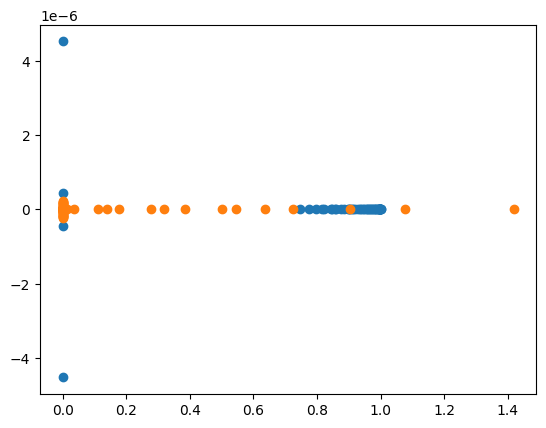

In [41]:
import matplotlib.pyplot as plt
N = phi_t.shape[0]
plt.scatter(e0.real, e0.imag)
plt.scatter(e1.real, e1.imag)

In [42]:
eig_result = lol.eig(markov_model, cov_XY)

In [43]:
e_fun = lol.evaluate_eigenfunction(eig_result, "right", phi_t)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.4498291 , -2.41114855, -2.372468  , -2.33378745, -2.2951069 ,
        -2.25642635, -2.2177458 , -2.17906524, -2.14038469, -2.10170414,
        -2.06302359, -2.02434304, -1.98566249, -1.94698194, -1.90830139,
        -1.86962084, -1.83094028, -1.79225973, -1.75357918, -1.71489863,
        -1.67621808, -1.63753753, -1.59885698, -1.56017643, -1.52149588,
        -1.48281533, -1.44413477, -1.40545422, -1.36677367, -1.32809312,
        -1.28941257, -1.25073202, -1.21205147, -1.17337092, -1.13469037,
        -1.09600981, -1.05732926, -1.01864871, -0.97996816, -0.94128761,
        -0.90260706, -0.86392651, -0.82524596, -0.78656541, -0.74788486,
        -0.7092043 , -0.67052375, -0.6318432 , -0.59316265, -0.5544821 ,
        -0.51580155, -0.477121  , -0.43844045, -0.3997599 , -0.36107934,
        -0.32239879, -0.28371824, -0.24503769, -0.20635714, -0.16767659,
        -0.12899604, -0.09031549, -0.05163494, -0.01295439,  0.02572617,
         0.06440672,  0.10308727,  0.14176782,  0.18044837,  0.21912892,
         0.25780947,  0.29649002,  0.33517057,  0.37385113,  0.41253168,
         0.45121223,  0.48989278,  0.52857333,  0.56725388,  0.60593443,
         0.64461498,  0.68329553,  0.72197608,  0.76065664,  0.79933719,
         0.83801774,  0.87669829,  0.91537884,  0.95405939,  0.99273994,
         1.03142049,  1.07010104,  1.1087816 ,  1.14746215,  1.1861427 ,
         1.22482325,  1.2635038 ,  1.30218435,  1.3408649 ,  1.37954545,
         1.418226  ]),
 array([-1.75411975, -1.72607586, -1.69803196, -1.66998806, -1.64194416,
        -1.61390026, -1.58585636, -1.55781247, -1.52976857, -1.50172467,
        -1.47368077, -1.44563687, -1.41759297, -1.38954908, -1.36150518,
        -1.33346128, -1.30541738, -1.27737348, -1.24932958, -1.22128569,
        -1.19324179, -1.16519789, -1.13715399, -1.10911009, -1.08106619,
        -1.0530223 , -1.0249784 , -0.9969345 , -0.9688906 , -0.9408467 ,
        -0.9128028 , -0.88475891, -0.85671501, -0.82867111, -0.80062721,
        -0.77258331, -0.74453941, -0.71649552, -0.68845162, -0.66040772,
        -0.63236382, -0.60431992, -0.57627602, -0.54823213, -0.52018823,
        -0.49214433, -0.46410043, -0.43605653, -0.40801263, -0.37996873,
        -0.35192484, -0.32388094, -0.29583704, -0.26779314, -0.23974924,
        -0.21170534, -0.18366145, -0.15561755, -0.12757365, -0.09952975,
        -0.07148585, -0.04344195, -0.01539806,  0.01264584,  0.04068974,
         0.06873364,  0.09677754,  0.12482144,  0.15286533,  0.18090923,
         0.20895313,  0.23699703,  0.26504093,  0.29308483,  0.32112872,
         0.34917262,  0.37721652,  0.40526042,  0.43330432,  0.46134822,
         0.48939211,  0.51743601,  0.54547991,  0.57352381,  0.60156771,
         0.62961161,  0.6576555 ,  0.6856994 ,  0.7137433 ,  0.7417872 ,
         0.7698311 ,  0.797875  ,  0.82591889,  0.85396279,  0.88200669,
         0.91005059,  0.93809449,  0.96613839,  0.99418228,  1.02222618,
         1.05027008]),
 <matplotlib.collections.QuadMesh at 0x7fc7cf025510>)

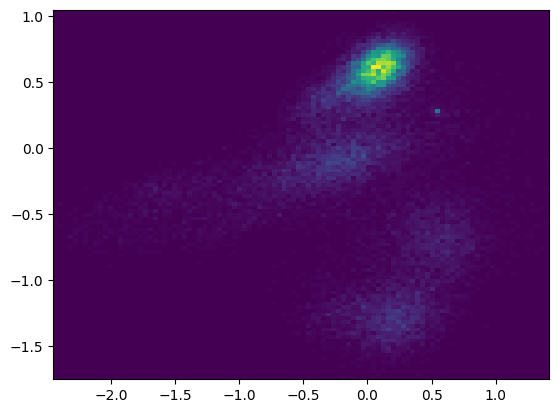

In [47]:
plt.hist2d(e_fun[:, -3].real, e_fun[:, -2].real, bins=100)